<a href="https://colab.research.google.com/github/bokuwakira1411/Data-mining---ex2-3/blob/main/exercise_2%2B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Xử lý dữ liệu training set

In [ ]:

df_train = pd.read_csv("/content/labeled_train.csv")
df_train.head()

,Date,Time,Open,High,Low,Close,Volume,Label
0,2011-01-03,01:00,1415.71,1416.54,1415.10,1415.63,1035,SELL
1,2011-01-03,02:00,1415.64,1416.43,1414.90,1415.98,736,SELL
2,2011-01-03,03:00,1415.95,1417.89,1414.59,1416.54,922,SELL
3,2011-01-03,04:00,1416.51,1418.64,1415.25,1416.75,1060,SELL
4,2011-01-03,05:00,1416.76,1420.00,1416.76,1419.48,838,SELL


In [ ]:
df_train.isnull().sum()

,0
Date,0
Time,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


In [ ]:
df_train['Date Time'] = pd.to_datetime(df_train['Date'] + ' ' + df_train['Time'])
df_train = df_train.set_index('Date Time').drop(columns=['Date', 'Time'])
df_train.head()

# Line plot

In [ ]:
df_train.dtypes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df_train['Open'].plot(title='Giá Open theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('Open Price')
plt.grid(True)
plt.show()


In [ ]:
df_train['Close'].plot(title='Giá Close theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [ ]:
df_train['High'].plot(title='Giá High theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('High Price')
plt.grid(True)
plt.show()


In [ ]:
df_train['Low'].plot(title='Giá Low theo thời gian', marker='o',figsize=(12, 6))
plt.xlabel('Thời gian')
plt.ylabel('Low Price')
plt.grid(True)
plt.show()


### Sample dữ liệu bị thiếu

In [ ]:
# Xử lý thiếu dữ liệu bằng phương pháp forward fill cho 10 phút ngay sau, nếu vẫn cần sample tiếp thì sử dụng interpolate time.

df_train['source'] = 'original'     # Thêm cột đánh dấu là dữ liệu sample hay original
df_train_resampled = df_train.resample('1T').ffill(limit=10)
df_train_resampled = df_train_resampled.interpolate(method='time')

# # Đánh dấu các dòng nào là original (có trong index gốc)
df_train_resampled['source'] = df_train_resampled.index.isin(df_train.index)
df_train_resampled['source'] = df_train_resampled['source'].map({True: 'original', False: 'sampled'})

df_train_resampled.iloc[55:65]

In [ ]:
print(df_train.shape)
print(df_train_resampled.shape)

### Tính toán để gán Label cho dữ liệu vừa sample được

In [ ]:
# Gán label cho dữ liệu đã sample (chỉ dữ liệu sử dụng interpolate time,
# vì dữ liệu sample 10 phút ban đầu bằng bfill chỉ điền giống dữ liệu gần nhất nên không cần gán lại Label)

delta_minutes = 30
threshold = 0.000505
df_train_resampled['price_future'] = df_train_resampled['Close'].shift(-delta_minutes)

mask_no_label = df_train_resampled['Label'].isna()

df_train_resampled.loc[mask_no_label, 'Label'] = np.select(
    [
        df_train_resampled.loc[mask_no_label, 'price_future'] > df_train_resampled.loc[mask_no_label, 'Close'] * (1 + threshold),
        df_train_resampled.loc[mask_no_label, 'price_future'] < df_train_resampled.loc[mask_no_label, 'Close'] * (1 - threshold)
    ],
    ['BUY', 'SELL'],
    default='HOLD'
)
df_train_resampled.drop(columns='price_future', inplace= True)
df_train_resampled.iloc[55:65]

### Tính toán các cột dữ liệu thành % thay đổi so với thời điểm ngay trước

In [ ]:
change_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

df = df_train_resampled.copy()

# Tính phần trăm thay đổi (returns) cho từng cột
for col in change_cols:
    df[f'{col}_return'] = df[col].pct_change()

# Loại bỏ dòng đầu tiên (vì không có dữ liệu để tính % thay đổi)
df_train_return = df.dropna(subset=[f'{col}_return' for col in change_cols])

df_train_return.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

df_train_return.tail()

### Tính toán các chỉ số kỹ thuật


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def calculate_all_technical_indicators(df):
    # Tạo bản copy để không thay đổi dataframe gốc
    df = df.copy()

    # 1. MACD (Moving Average Convergence Divergence)
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # 2. RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 3. Bollinger Bands
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['BB_upper'] = df['SMA_20'] + 2 * df['Close'].rolling(window=20).std()
    df['BB_lower'] = df['SMA_20'] - 2 * df['Close'].rolling(window=20).std()
    df['BB_width'] = df['BB_upper'] - df['BB_lower']

    # 4. Ichimoku Cloud
    # Tenkan-sen (Conversion Line)
    nine_period_high = df['High'].rolling(window=9).max()
    nine_period_low = df['Low'].rolling(window=9).min()
    df['Tenkan_sen'] = (nine_period_high + nine_period_low) / 2

    # Kijun-sen (Base Line)
    twenty_six_period_high = df['High'].rolling(window=26).max()
    twenty_six_period_low = df['Low'].rolling(window=26).min()
    df['Kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

    # Senkou Span A (Leading Span A)
    df['Senkou_A'] = ((df['Tenkan_sen'] + df['Kijun_sen']) / 2).shift(26)

    # Senkou Span B (Leading Span B)
    fifty_two_period_high = df['High'].rolling(window=52).max()
    fifty_two_period_low = df['Low'].rolling(window=52).min()
    df['Senkou_B'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(26)

    # Chikou Span (Lagging Span)
    df['Chikou_span'] = df['Close'].shift(-26)

    # 5. ATR (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()

    # Xóa các cột trung gian không cần thiết
    df.drop(['EMA_12', 'EMA_26', 'SMA_20'], axis=1, inplace=True, errors='ignore')

    return df

# Tính toán tất cả chỉ báo
df_train_with_indicators = calculate_all_technical_indicators(df_train_resampled)

In [ ]:
df_train_with_indicators.dropna(inplace=True)
df_train_with_indicators.head()

### Chuẩn hoá dữ liệu Z-score, đưa dữ liệu về phân phối có trung bình = 0 và độ lệch chuẩn = 1

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'Tenkan_sen', 'Kijun_sen', 'Senkou_A', 'Senkou_B',
    'Chikou_span', 'ATR'
]
scaler = StandardScaler()

# Fit và transform
df_train_with_indicators[feature_cols] = scaler.fit_transform(df_train_with_indicators[feature_cols])
df_train_with_indicators.tail()

## Xử lý dữ liệu development set

In [ ]:
df_dev = pd.read_csv("/content/labeled_dev.csv")
df_dev.head()

In [ ]:
df_dev.isnull().sum()

In [ ]:
df_dev['Date Time'] = pd.to_datetime(df_dev['Date'] + ' ' + df_dev['Time'])
df_dev = df_dev.set_index('Date Time').drop(columns=['Date', 'Time'])
df_dev.head()

In [ ]:
df_dev.shape

### Sample dữ liệu

In [ ]:
# Xử lý thiếu dữ liệu bằng phương pháp forward fill cho 10 phút ngay sau, nếu vẫn cần sample tiếp thì sử dụng interpolate time.

df_dev['source'] = 'original'     # Thêm cột đánh dấu là dữ liệu sample hay original
df_dev_resampled = df_dev.resample('1T').ffill(limit=10)
df_dev_resampled = df_dev_resampled.interpolate(method='time')

# # Đánh dấu các dòng nào là original (có trong index gốc)
df_dev_resampled['source'] = df_dev_resampled.index.isin(df_dev.index)
df_dev_resampled['source'] = df_dev_resampled['source'].map({True: 'original', False: 'sampled'})

df_dev_resampled.head()

In [ ]:
df_dev_resampled.shape

### Gán nhãn dữ liệu được sample

In [ ]:
# Gán label cho dữ liệu đã sample (chỉ dữ liệu sử dụng interpolate time,
# vì dữ liệu sample 10 phút ban đầu bằng bfill chỉ điền giống dữ liệu gần nhất nên không cần gán lại Label)

delta_minutes = 30
threshold = 0.000505
df_dev_resampled['price_future'] = df_dev_resampled['Close'].shift(-delta_minutes)

mask_no_label = df_dev_resampled['Label'].isna()

df_dev_resampled.loc[mask_no_label, 'Label'] = np.select(
    [
        df_dev_resampled.loc[mask_no_label, 'price_future'] > df_dev_resampled.loc[mask_no_label, 'Close'] * (1 + threshold),
        df_dev_resampled.loc[mask_no_label, 'price_future'] < df_dev_resampled.loc[mask_no_label, 'Close'] * (1 - threshold)
    ],
    ['BUY', 'SELL'],
    default='HOLD'
)
df_dev_resampled.drop(columns='price_future', inplace= True)
df_dev_resampled[df_dev_resampled['source']=='sampled'][:5]

### Tính toán % thay đổi

In [ ]:
change_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

df = df_dev_resampled.copy()

# Tính phần trăm thay đổi (returns) cho từng cột
for col in change_cols:
    df[f'{col}_return'] = df[col].pct_change()

# Loại bỏ dòng đầu tiên (vì không có dữ liệu để tính % thay đổi)
df_dev_return = df.dropna(subset=[f'{col}_return' for col in change_cols])

df_dev_return.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

df_dev_return.tail()

### Tính toán các chỉ số kỹ thuật


In [ ]:
df_dev_with_indicators = calculate_all_technical_indicators(df_dev_resampled)
df_dev_with_indicators.dropna(inplace=True)
df_dev_with_indicators.head()

### Chuẩn hoá Z-score

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'RSI', 'BB_upper', 'BB_lower', 'BB_width',
    'Tenkan_sen', 'Kijun_sen', 'Senkou_A', 'Senkou_B',
    'Chikou_span', 'ATR'
]
scaler = StandardScaler()

# Fit và transform
df_dev_with_indicators[feature_cols] = scaler.fit_transform(df_dev_with_indicators[feature_cols])
df_dev_with_indicators.tail()

# MÔ HÌNH

In [ ]:
df_train_resampled.shape

Mã hoá nhãn

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train_resampled['Label'] = le.fit_transform(df_train_resampled['Label'])

In [ ]:
df_train_resampled['Label']

In [ ]:
df = df_train_resampled.drop(columns = ['source'])

In [ ]:
data = df.values
features = data[:,1:]
labels = data[:, 0]

In [ ]:
features.shape

In [ ]:
labels

In [ ]:
window_size=10000
X, y = [], []
for i in range(len(df) - window_size):
    x_seq = features[i:i+window_size]
    label = labels[i+window_size]  # nhãn tại bước tiếp theo
    X.append(x_seq)
    y.append(label)

X = np.array(X)  # (num_samples, 128, 5)
y = np.array(y).astype(np.float32).reshape(-1, 1)  # (num_samples, 1)



In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


Thiết kế mô hình Transformers (ver 1)
- Transformer thông thường + Time2Vec
- Tầng Fully Connected sẽ thực hiện tác vụ phân lớp

Với 5 triệu dòng, ta nên chia nhỏ để train mô hình, để sử dụng time2vec thì ta cần 1 tầng linear có size k*2 (số giá trị w và phi)

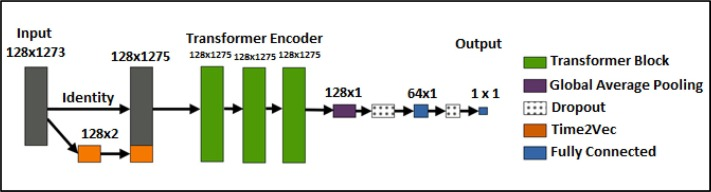

1. Input -> Time2Vec encoding + positional encoding

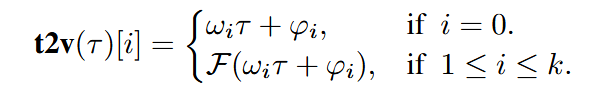

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

In [ ]:
class Time2Vec(nn.Module):
  def __init__(self, seq_len, kernel_size):
    super(Time2Vec, self).__init__()
    self.linear = nn.Linear(1,1)      #i = 0
    self.seq_len = seq_len
    self.periodic = nn.Linear(1, kernel_size-1) # i = 1:k
  def forward(self, x):
    seq_len = x.size(1)
    t = torch.arange(seq_len).float().unsqueeze(1).to(x.device)
    lin = self.linear(t)
    sin = torch.sin(self.self.periodic(t)) # F: sin
    time_embedding = torch.cat([lin, sin], dim=1)  # (seq_len, out_features)
    time_embedding = time_embedding.unsqueeze(0).repeat(x.size(0), 1, 1)  # (batch_size, seq_len, out_features)
    return time_embedding

Các chỉ số đầu vào:
- số lượng đặc trưng: input_dim
- số chiều của time2vec: time2vec_dim
- số chiều của vector biểu diễn cho mỗi bước thời gian: d_model


In [ ]:
class Transformer(nn.Module):
  def __init__(self,seq_len, input_dim, time2vec_dim, d_model, nhead, num_layers, num_outputs):
    super(Transformer, self).__init__()
    self.time2vec = Time2Vec(seq_len,time2vec_dim)
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(d_model, 32)
    self.fc2 = nn.Linear(32,1)
  def forward(self, x):
    t2v = self.time2vec(x) # (batch_size, seq_len, time2vec_dim)
    x = torch.cat([x, t2v], dim=-1) #(batch_size, seq_len, time2vec_dim + input_dim)
    x = self.encoder(x)
    x = x.transpose(1,2) #(batch_size, total_input_dim, seq_len)
    x = self.global_avg_pool(x).squeeze(-1)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.fc2(x))
    return x